In [1]:
cd Downloads/

/Users/sagarsahoo/Downloads


In [6]:
import pandas as pd 
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline 
import plotly.graph_objs as go
import plotly.figure_factory as ff
from plotly import tools
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
init_notebook_mode(connected=True)


import gc
from datetime import datetime 
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.metrics import roc_auc_score
from sklearn.ensemble import RandomForestClassifier

pd.set_option('display.max_columns', 100)


RFC_METRIC = 'gini'  #metric used for RandomForrestClassifier
NUM_ESTIMATORS = 100 #number of estimators used for RandomForrestClassifier
NO_JOBS = 4 #number of parallel jobs used for RandomForrestClassifier


#TRAIN/VALIDATION/TEST SPLIT
#VALIDATION
VALID_SIZE = 0.20 # simple validation using train_test_split
TEST_SIZE = 0.20 # test size using_train_test_split

#CROSS-VALIDATION
NUMBER_KFOLDS = 5 #number of KFolds for cross-validation



RANDOM_STATE = 2018

MAX_ROUNDS = 1000 #lgb iterations
EARLY_STOP = 50 #lgb early stop 

OPT_ROUNDS = 1000  #To be adjusted based on best validation rounds
VERBOSE_EVAL = 50 #Print out metric result

IS_LOCAL = False

In [16]:
data_df = pd.read_csv("creditcard.csv")
data_df.head(5)

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,-0.551600,-0.617801,-0.991390,-0.311169,1.468177,-0.470401,0.207971,0.025791,0.403993,0.251412,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,1.612727,1.065235,0.489095,-0.143772,0.635558,0.463917,-0.114805,-0.183361,-0.145783,-0.069083,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,0.624501,0.066084,0.717293,-0.165946,2.345865,-2.890083,1.109969,-0.121359,-2.261857,0.524980,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,-0.226487,0.178228,0.507757,-0.287924,-0.631418,-1.059647,-0.684093,1.965775,-1.232622,-0.208038,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,-0.822843,0.538196,1.345852,-1.119670,0.175121,-0.451449,-0.237033,-0.038195,0.803487,0.408542,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [17]:
data_df.Class.value_counts()

0    284315
1       492
Name: Class, dtype: int64

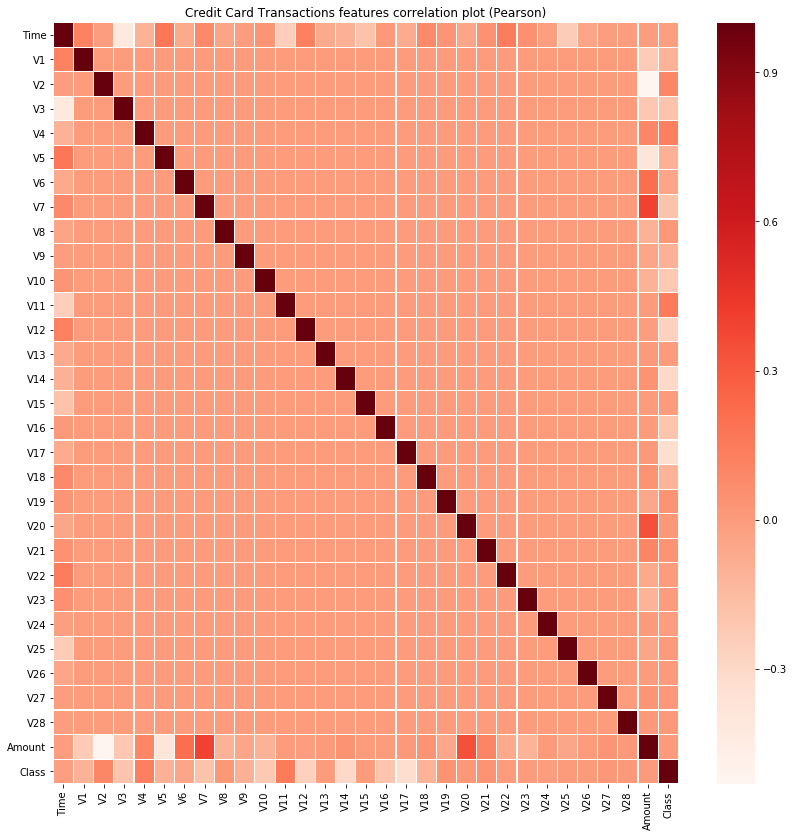

In [18]:
plt.figure(figsize = (14,14))
plt.title('Credit Card Transactions features correlation plot (Pearson)')
corr = data_df.corr()
sns.heatmap(corr,xticklabels=corr.columns,yticklabels=corr.columns,linewidths=.1,cmap="Reds")
plt.show()

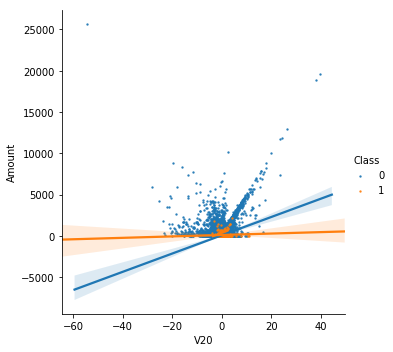

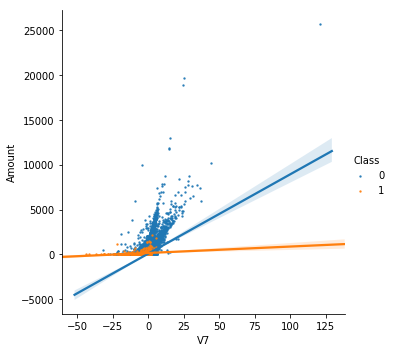

In [19]:
s = sns.lmplot(x='V20', y='Amount',data = data_df, hue='Class', fit_reg=True,scatter_kws={'s':2})
s = sns.lmplot(x='V7', y='Amount',data=data_df, hue='Class', fit_reg=True,scatter_kws={'s':2})
plt.show()

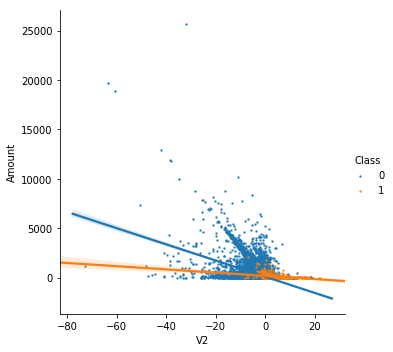

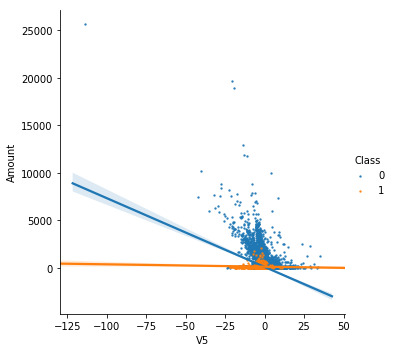

In [21]:
s = sns.lmplot(x='V2', y='Amount',data=data_df, hue='Class', fit_reg=True,scatter_kws={'s':2})
s = sns.lmplot(x='V5', y='Amount',data=data_df, hue='Class', fit_reg=True,scatter_kws={'s':2})
plt.show()

In [28]:
target = 'Class'
predictors = ['Time', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10',
       'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19',
       'V20', 'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28',
       'Amount']

In [29]:
train_df, test_df = train_test_split(data_df, test_size=TEST_SIZE, random_state=RANDOM_STATE, shuffle=True )
train_df, valid_df = train_test_split(train_df, test_size=VALID_SIZE, random_state=RANDOM_STATE, shuffle=True )

In [24]:
clf = RandomForestClassifier(n_jobs= 4, random_state=2018 , criterion='gini', n_estimators= 100, verbose=False)

In [34]:
clf.fit(train_df[predictors], train_df[target].values)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=4,
            oob_score=False, random_state=2018, verbose=False,
            warm_start=False)

In [35]:
preds = clf.predict(valid_df[predictors])

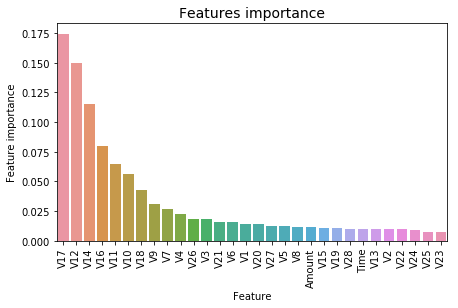

In [36]:
tmp = pd.DataFrame({'Feature': predictors, 'Feature importance': clf.feature_importances_})
tmp = tmp.sort_values(by='Feature importance',ascending=False)
plt.figure(figsize = (7,4))
plt.title('Features importance',fontsize=14)
s = sns.barplot(x='Feature',y='Feature importance',data=tmp)
s.set_xticklabels(s.get_xticklabels(),rotation=90)
plt.show()  

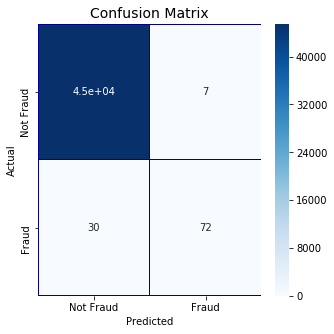

In [37]:
cm = pd.crosstab(valid_df[target].values, preds, rownames=['Actual'], colnames=['Predicted'])
fig, (ax1) = plt.subplots(ncols=1, figsize=(5,5))
sns.heatmap(cm, 
            xticklabels=['Not Fraud', 'Fraud'],
            yticklabels=['Not Fraud', 'Fraud'],
            annot=True,ax=ax1,
            linewidths=.2,linecolor="Darkblue", cmap="Blues")
plt.title('Confusion Matrix', fontsize=14)
plt.show()

In [38]:
cm

Predicted,0,1
Actual,,
0,45460,7
1,30,72


In [39]:
roc_auc_score(valid_df[target].values, preds)

0.8528641975628091

In [42]:
clf2 = RandomForestClassifier(n_jobs= 4, random_state=2018 , criterion='gini', n_estimators= 200, verbose=False)

In [43]:
clf2.fit(train_df[predictors], train_df[target].values)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=200, n_jobs=4,
            oob_score=False, random_state=2018, verbose=False,
            warm_start=False)

In [44]:
preds2 = clf2.predict(valid_df[predictors])

In [45]:
cm = pd.crosstab(valid_df[target].values, preds2, rownames=['Actual'], colnames=['Predicted'])

In [46]:
cm

Predicted,0,1
Actual,,
0,45462,5
1,30,72


In [49]:
clf2.score(valid_df[predictors], preds2)

1.0

In [50]:
clf.score(valid_df[predictors], preds2)

0.9999561105137265

In [51]:
roc_auc_score(valid_df[target].values, preds)

0.8528641975628091

In [52]:
roc_auc_score(valid_df[target].values, preds2)

0.8528861915364603

In [54]:
clf4 = RandomForestClassifier(n_jobs= 2, random_state=2018 , criterion='gini', n_estimators= 50, verbose=False)

In [55]:
clf4.fit(train_df[predictors], train_df[target].values)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=50, n_jobs=2,
            oob_score=False, random_state=2018, verbose=False,
            warm_start=False)

In [56]:
preds4 = clf4.predict(valid_df[predictors])

In [57]:
cm = pd.crosstab(valid_df[target].values, preds4, rownames=['Actual'], colnames=['Predicted'])

In [58]:
cm

Predicted,0,1
Actual,,
0,45462,5
1,31,71


In [60]:
print(clf4.score(valid_df[predictors], preds4))
print(roc_auc_score(valid_df[target].values, preds4))

1.0
0.8479842307521465


In [65]:
clf5 = RandomForestClassifier(n_jobs= 2, random_state=2018 , criterion='entropy', n_estimators= 100, verbose=False)

In [66]:
clf5.fit(train_df[predictors], train_df[target].values)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=2,
            oob_score=False, random_state=2018, verbose=False,
            warm_start=False)

In [74]:
preds5 = clf5.predict(valid_df[predictors])

In [75]:
cm = pd.crosstab(valid_df[target].values, preds5, rownames=['Actual'], colnames=['Predicted'])

In [76]:
cm

Predicted,0,1
Actual,,
0,45463,4
1,29,73


In [77]:
print(clf5.score(valid_df[predictors], preds5))

1.0


In [78]:
print(roc_auc_score(valid_df[target].values, preds5))

0.8577991493075996


In [72]:
clf6 = RandomForestClassifier(n_jobs= 2, random_state=2018 , criterion='entropy', n_estimators= 100, 
                              verbose=False,max_depth=5)

In [73]:
clf6.fit(train_df[predictors], train_df[target].values)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
            max_depth=5, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=2,
            oob_score=False, random_state=2018, verbose=False,
            warm_start=False)

In [79]:
preds6 = clf6.predict(valid_df[predictors])

In [84]:
cm = pd.crosstab(valid_df[target].values, preds6, rownames=['Actual'], colnames=['Predicted'])
print(cm)
print(clf6.score(valid_df[predictors], preds6))
print(roc_auc_score(valid_df[target].values, preds6))

Predicted      0   1
Actual              
0          45462   5
1             31  71
1.0
0.8479842307521465


In [82]:
clf7 = RandomForestClassifier(n_jobs= 2, random_state=2018 , criterion='entropy', n_estimators= 100, 
                              verbose=False,max_depth=5,max_features= 6)

In [83]:
clf7.fit(train_df[predictors], train_df[target].values)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
            max_depth=5, max_features=6, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=2,
            oob_score=False, random_state=2018, verbose=False,
            warm_start=False)

In [85]:
preds7 = clf7.predict(valid_df[predictors])
cm = pd.crosstab(valid_df[target].values, preds7, rownames=['Actual'], colnames=['Predicted'])
print(cm)
print(clf7.score(valid_df[predictors], preds7))
print(roc_auc_score(valid_df[target].values, preds7))

Predicted      0   1
Actual              
0          45464   3
1             31  71
1.0
0.8480062247257977


In [94]:
data_df.shape

(284807, 31)

In [95]:
preds7

array([0, 0, 0, ..., 0, 0, 0])

In [98]:
#data_df['predicted_class'] = preds7
#data_df.to_csv('credit_card_preds_26Sep.csv')

credit_card_preds_26Sep_df = pd.DataFrame()
credit_card_preds_26Sep_df = valid_df[predictors]
credit_card_preds_26Sep_df['actual_class']=valid_df[target].values
credit_card_preds_26Sep_df['pred_class']=preds7

In [99]:
credit_card_preds_26Sep_df.to_csv('credit_card_preds_26Sep.csv')

In [1]:
Reference_URL='https://www.kaggle.com/gpreda/credit-card-fraud-detection-predictive-models/data'